In [ ]:
%pip install azure-ai-vision-imageanalysis

## Helper Function

In [3]:
from matplotlib import pyplot as plt
import cv2

def show_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

## Load Azure Configuration

In [1]:
import os
azure_computer_vision_endpoint = os.environ["AZURE_COMPUTER_VISION_ENDPOINT"]
azure_computer_vision_key = os.environ["AZURE_COMPUTER_VISION_KEY"]

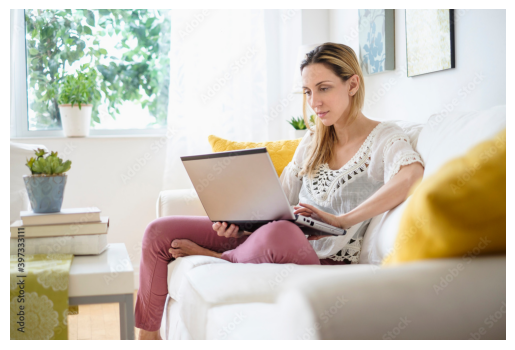

In [4]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

# Create an Image Analysis client
client = ImageAnalysisClient(
    endpoint=azure_computer_vision_endpoint,
    credential=AzureKeyCredential(azure_computer_vision_key)
)

image = "../Data/images/1.jpg"
show_image(image)

# Read the image file as bytes
with open(image, "rb") as image_file:
    image_data = image_file.read()

## Caption

In [5]:
# Get a caption for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.CAPTION],
    gender_neutral_caption=True,  # Optional (default is False)
)

print("Caption:")
if result.caption is not None:
    print(f"   '{result.caption.text}', Confidence {result.caption.confidence:.4f}")

Caption:
   'Shoshanna Withers sitting on a couch using a laptop', Confidence 0.8889


## Dense Caption

In [6]:
# Get a caption for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.DENSE_CAPTIONS],
    gender_neutral_caption=True,  # Optional (default is False)
)

print("Dense Captions:")
for item in result.dense_captions['values']:
    print(f"   '{item['text']}', Confidence {item['confidence']:.4f}")

Dense Captions:
   'a person sitting on a couch using a laptop', Confidence 0.8889
   'a person sitting on a couch holding a laptop', Confidence 0.7798
   'a person sitting on a couch using a laptop', Confidence 0.8874
   'a potted plant in front of a window', Confidence 0.8741
   'a plant in a pot', Confidence 0.8147
   'a screen with a white background', Confidence 0.6107
   'a plant in a pot', Confidence 0.8154
   'close-up of a yellow box with a white design', Confidence 0.7431
   'a close-up of a pillow', Confidence 0.7961
   'a person sitting on a couch', Confidence 0.7777
